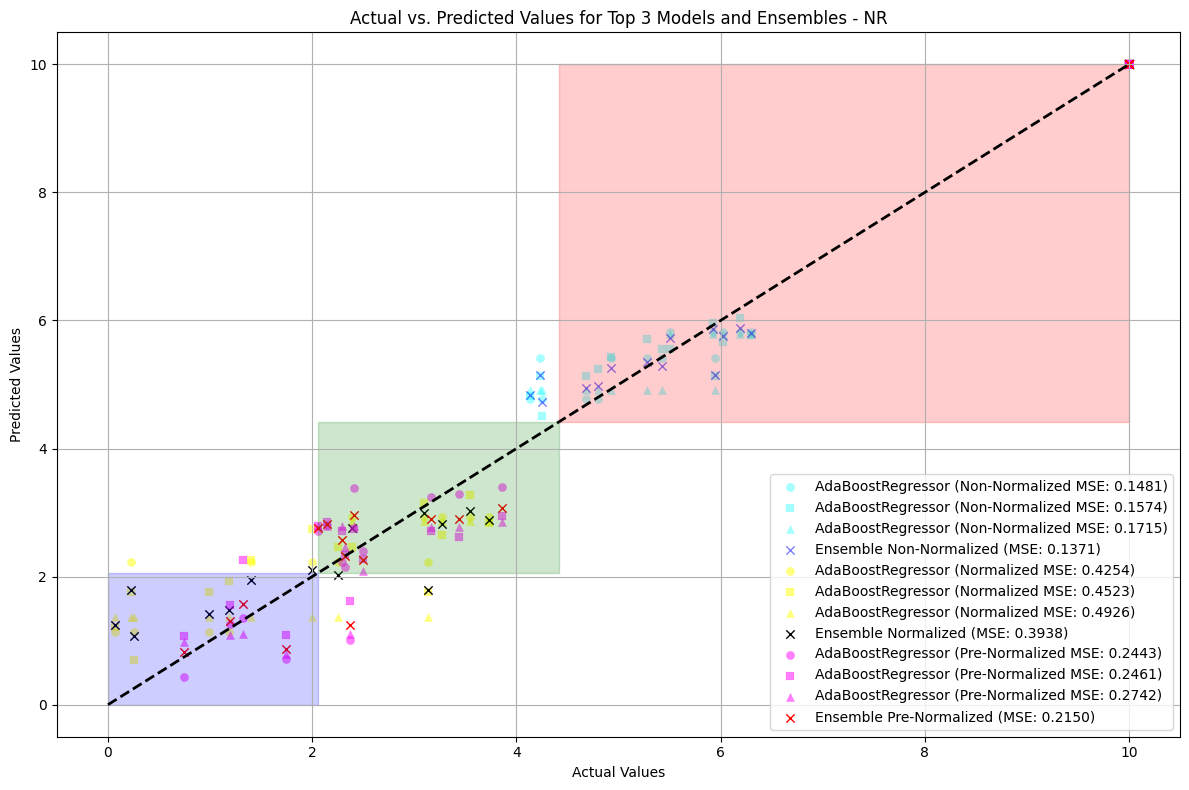

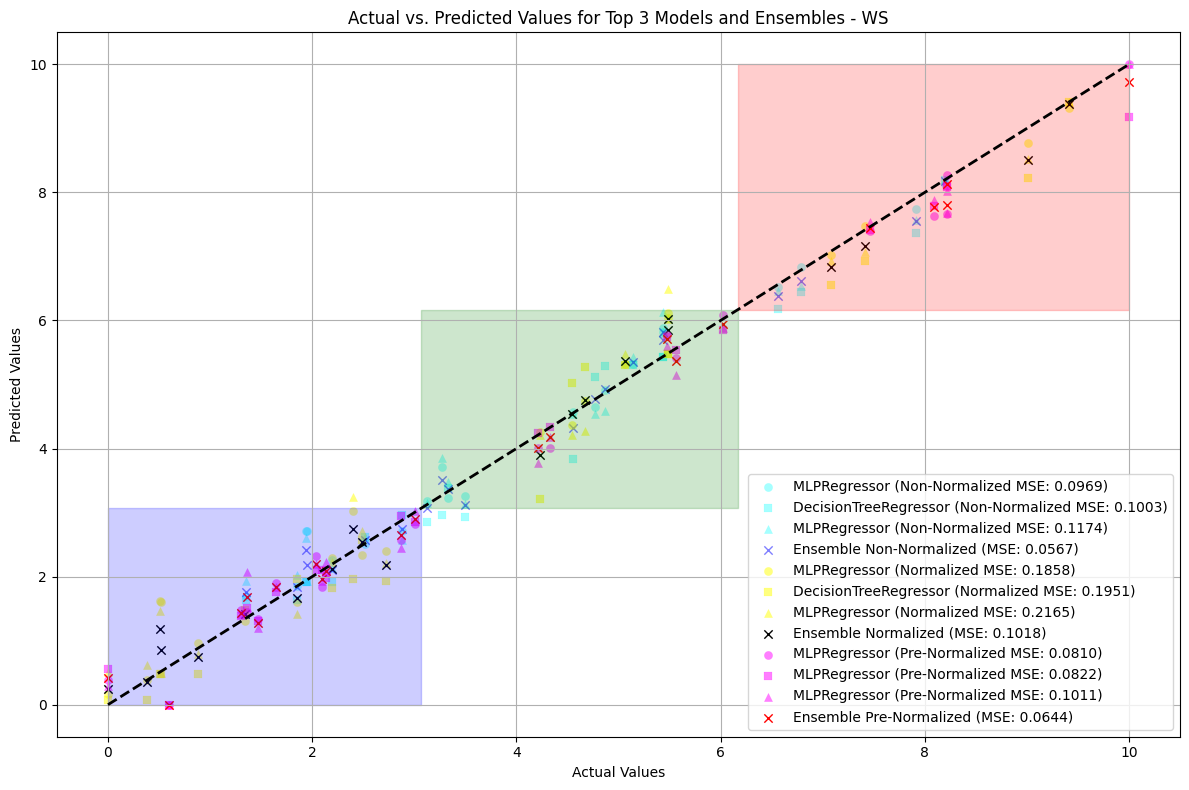

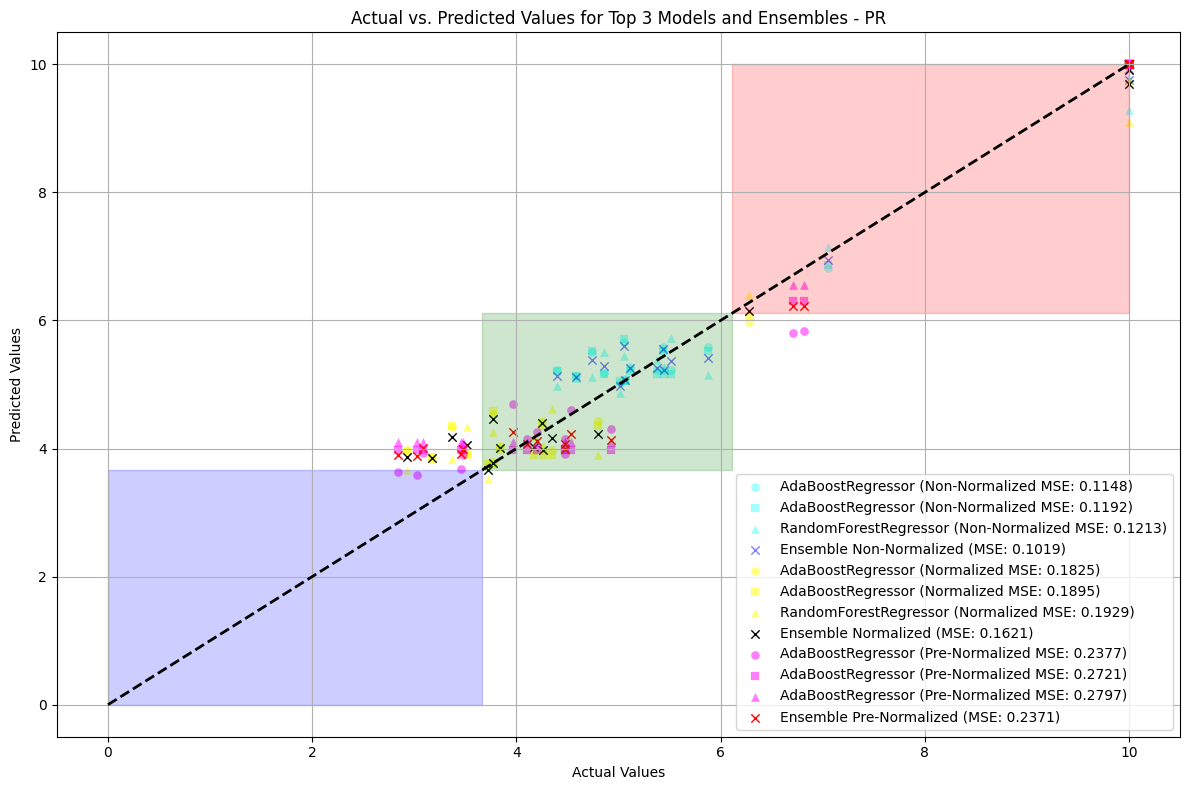

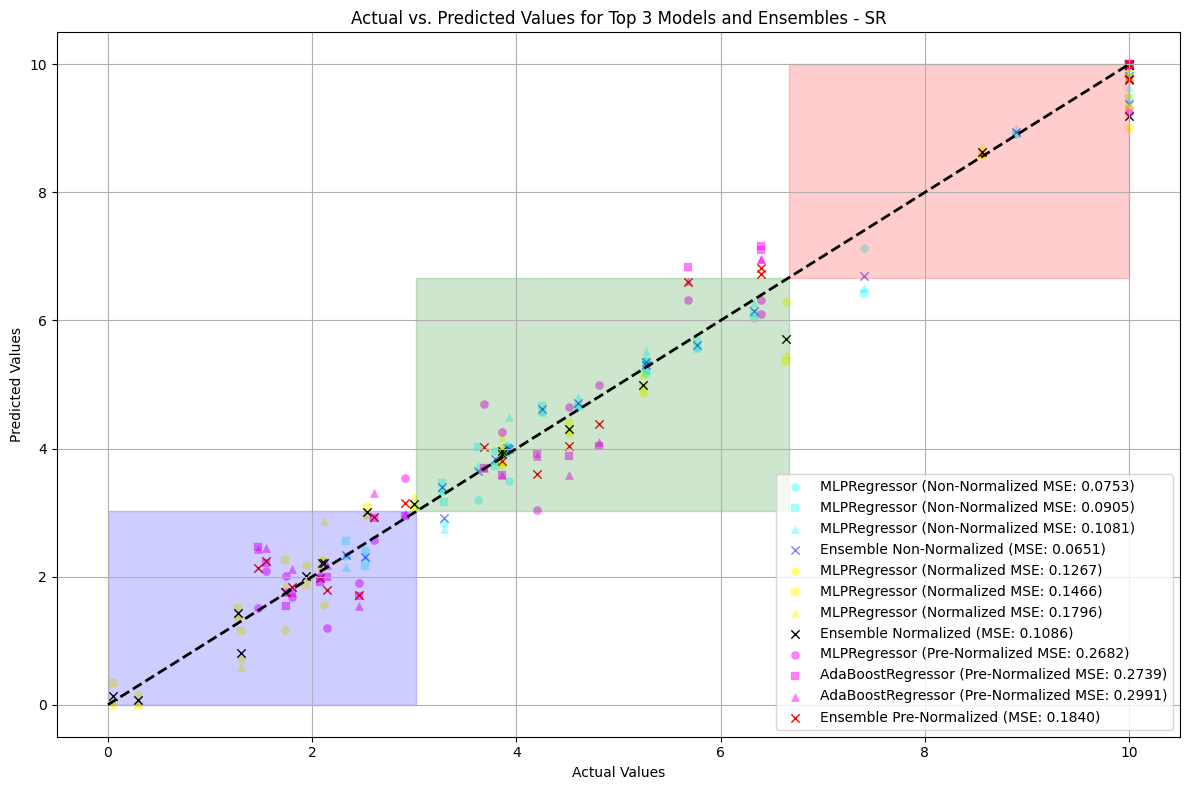

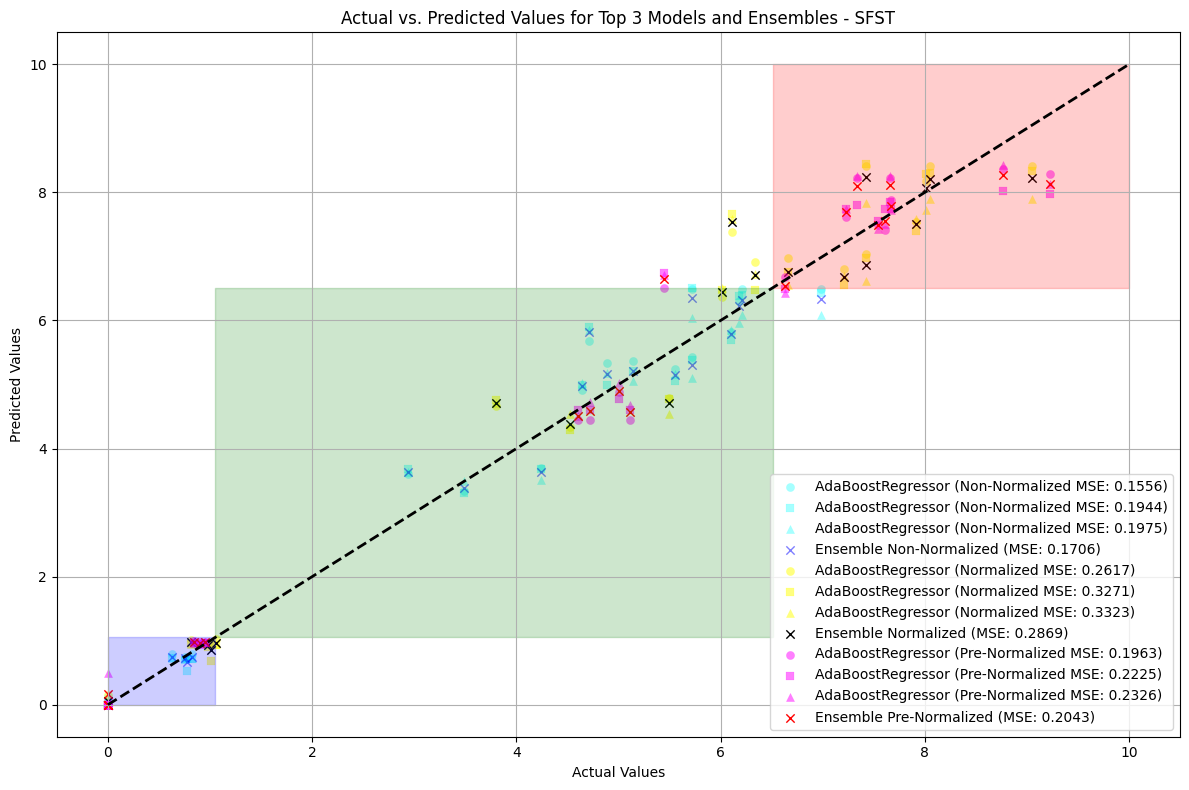

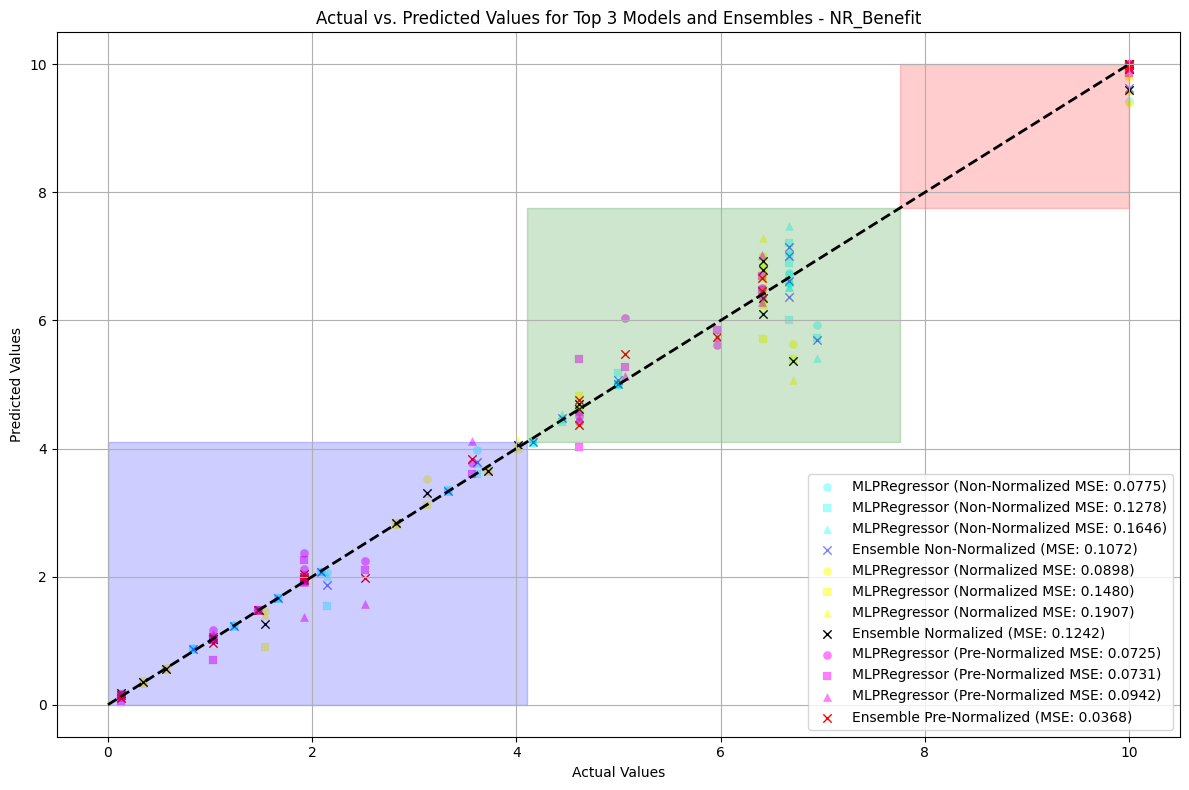

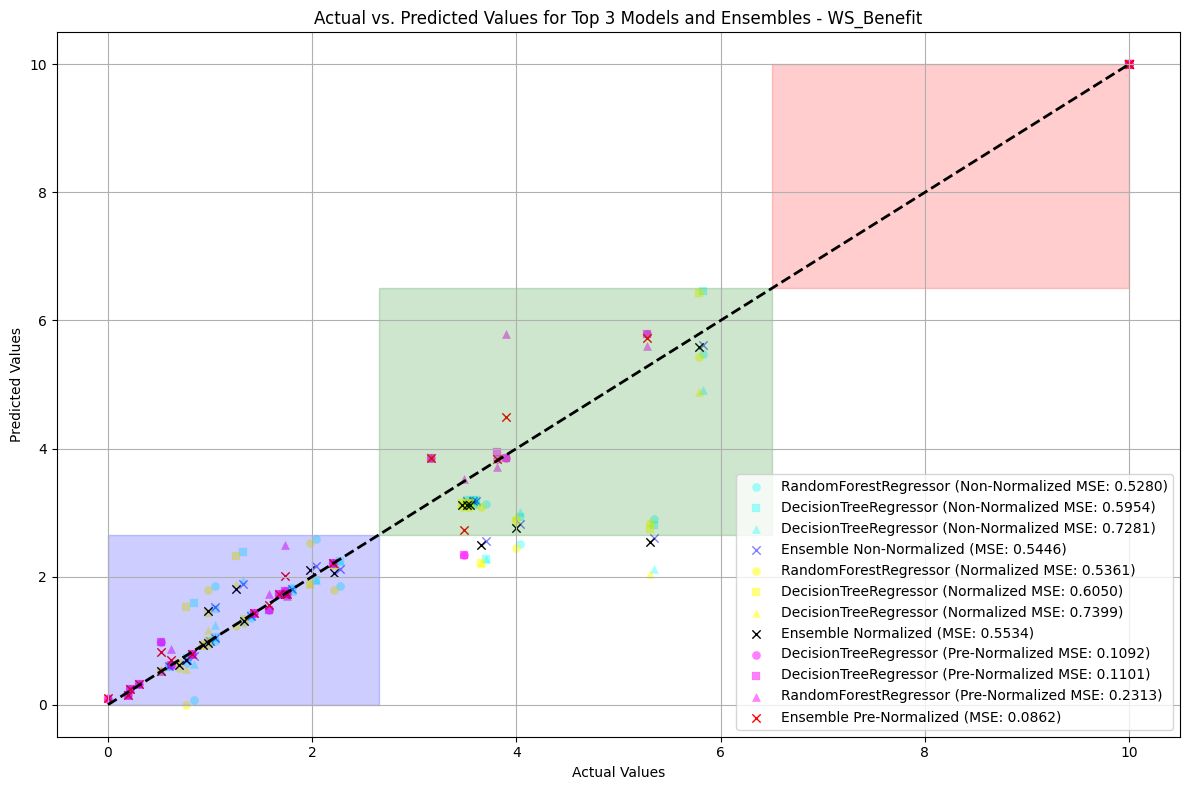

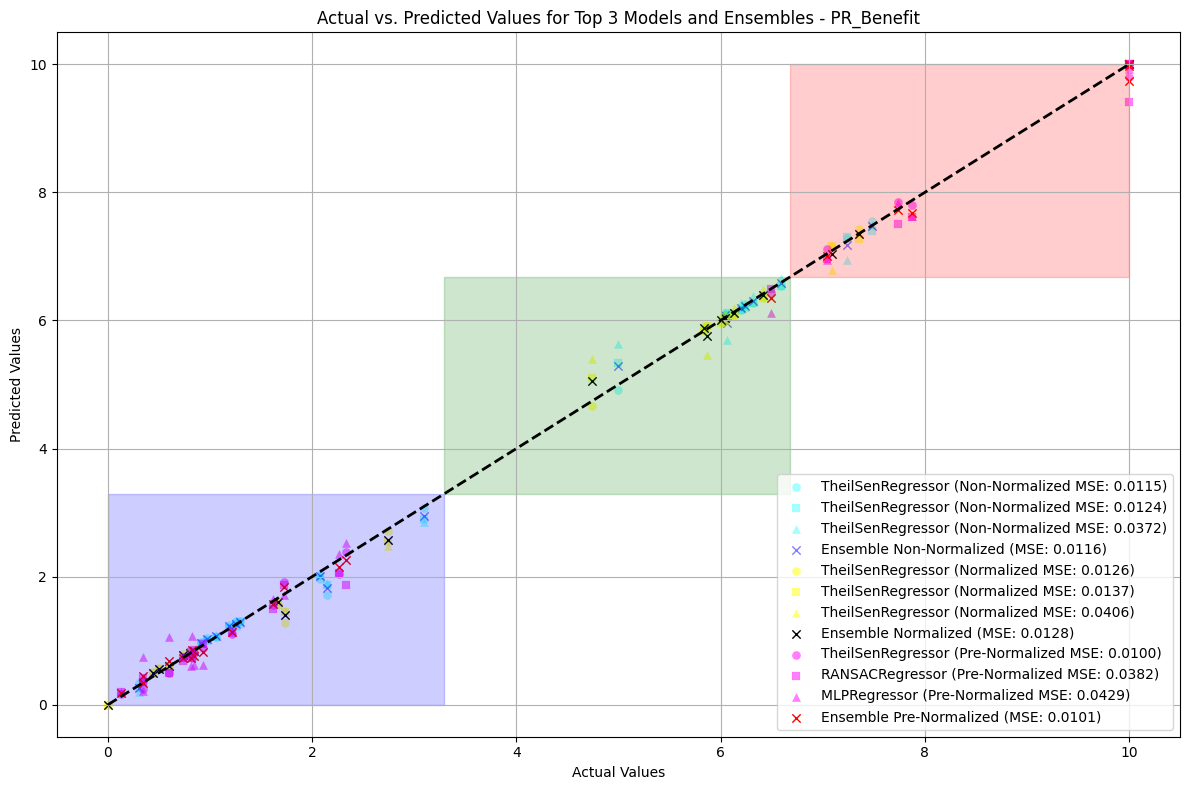

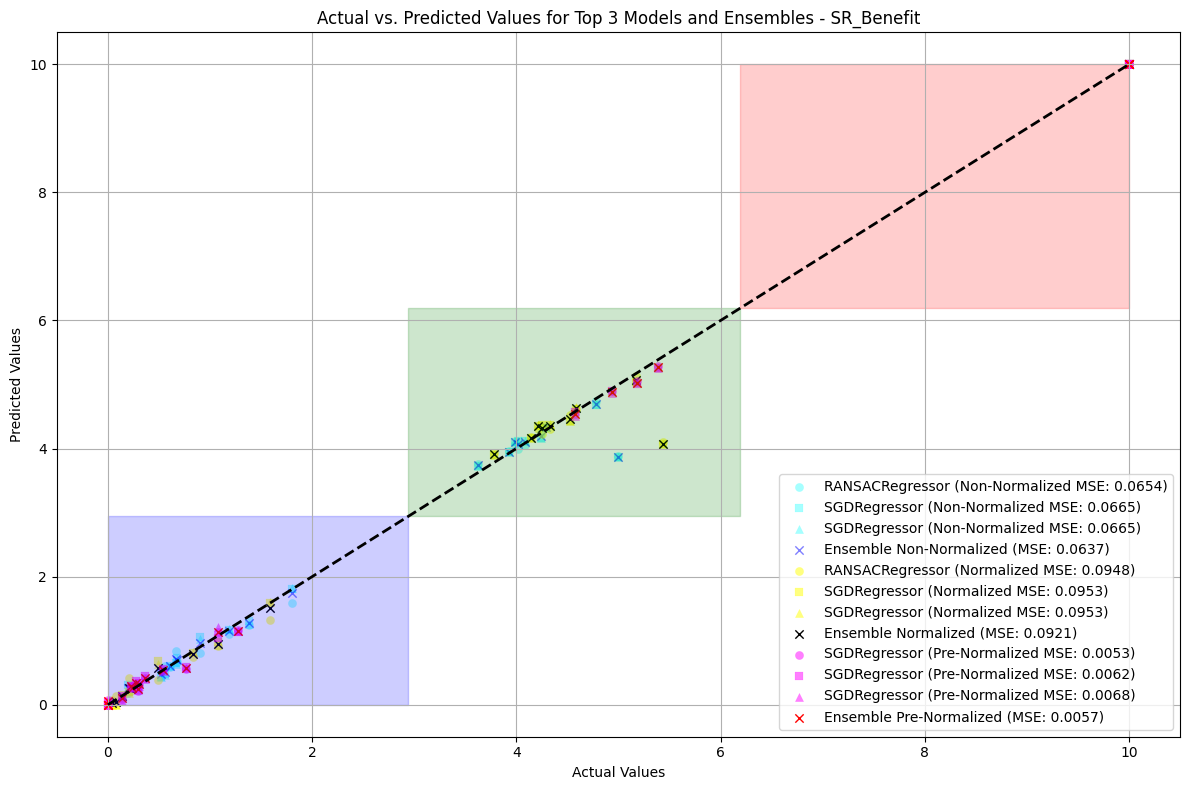

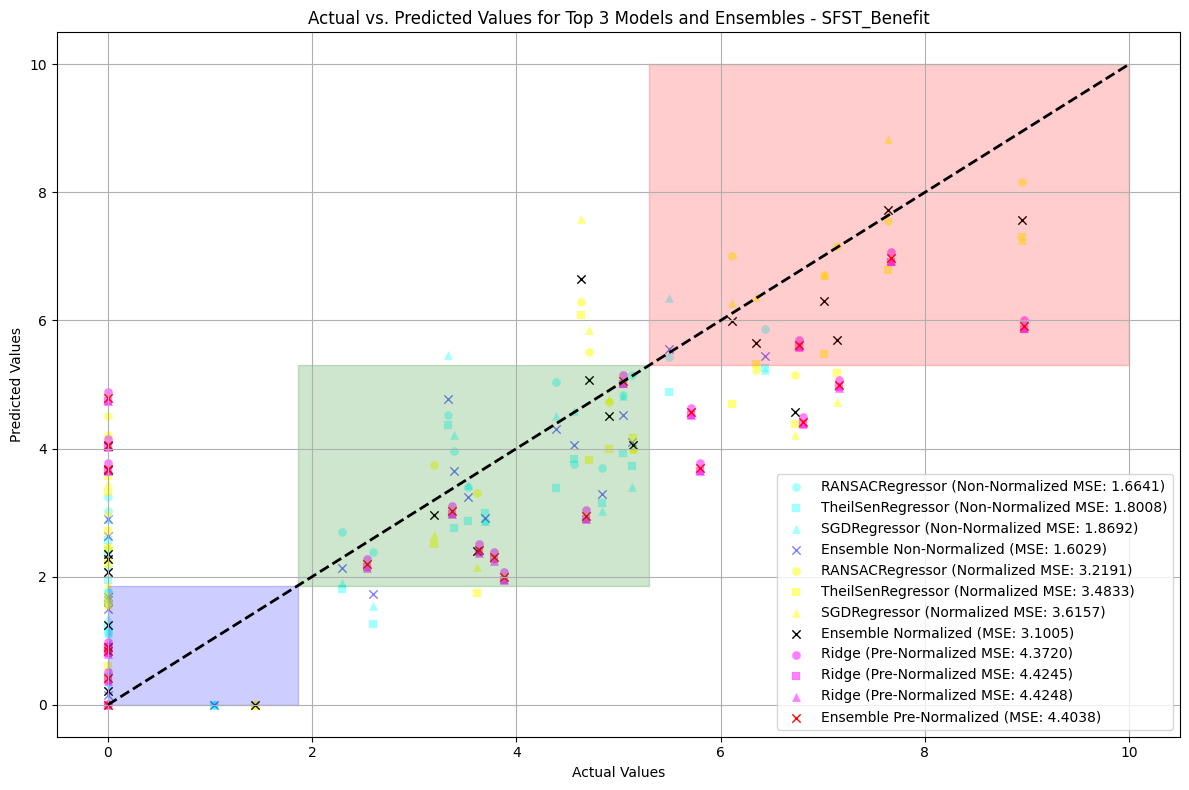

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd
from sklearn.metrics import mean_squared_error

# Configuration for prediction classes
config = {
    "WS": {"min": 1.58, "max": 8.61, "lower": 3.07, "higher": 6.17},
    "PR": {"min": 2.07, "max": 10.0, "lower": 3.66, "higher": 6.11},
    "NR": {"min": 4.10, "max": 10.0, "lower": 2.06, "higher": 4.42},
    "SR": {"min": 2.29, "max": 10.0, "lower": 3.02, "higher": 6.67},
    "SFST": {"min": 0.0, "max": 7.71, "lower": 1.05, "higher": 6.51},
    "WS_Benefit": {"min": 0.08, "max": 10.0, "lower": 2.65, "higher": 6.50},
    "PR_Benefit": {"min": 0.49, "max": 10.0, "lower": 3.29, "higher": 6.68},
    "NR_Benefit": {"min": 0.71, "max": 10.0, "lower": 4.10, "higher": 7.76},
    "SR_Benefit": {"min": 0.49, "max": 8.79, "lower": 2.94, "higher": 6.19},
    "SFST_Benefit": {"min": 0.0, "max": 7.19, "lower": 1.86, "higher": 5.30}
}

def normalize_predictions(predicted, actual, feature):
    min_val = config[feature]["min"]
    max_val = config[feature]["max"]
    predicted_clipped = np.clip(predicted, 0, 10)
    actual_clipped = np.clip(actual, 0, 10)
    return np.clip((predicted_clipped - min_val) / (max_val - min_val) * 10, 0, 10), np.clip((actual_clipped - min_val) / (max_val - min_val) * 10, 0, 10)

def plot_top_models(model_directory_non_norm, model_directory_norm, num_best_models, results_columns):
    feature = results_columns[0]  # Current feature being processed

    # Colors and markers for non-normalized, normalized by code, and pre-normalized datasets
    colors = {
        'non_norm': ['cyan', 'cyan', 'cyan'],
        'pre_norm': ['magenta', 'magenta', 'magenta'],
        'norm_by_code': ['yellow', 'yellow', 'yellow']
    }
    markers = ['o', 's', '^']

    plt.figure(figsize=(12, 8))

    # Process non-normalized directory
    model_mse = []
    normalized_model_mse = []
    csv_files = glob.glob(os.path.join(model_directory_non_norm, '*.csv'))
    for csv_file in csv_files:
        data = pd.read_csv(csv_file)
        for model in data['Model'].unique():
            model_data = data[data['Model'] == model]
            actual = np.clip(model_data['Actual'], 0, 10)  # Clip actual values to 0-10
            predicted = np.clip(model_data['Predicted'], 0, 10)  # Clip predicted values to 0-10

            # Calculate non-normalized MSE
            mse = mean_squared_error(actual, predicted)
            model_mse.append((model, mse, predicted, actual))

            # Calculate normalized MSE (for individual models only)
            predicted_norm, actual_norm = normalize_predictions(predicted, actual, feature)
            mse_norm = mean_squared_error(actual_norm, predicted_norm)
            normalized_model_mse.append((model, mse_norm, predicted_norm, actual_norm))

    model_mse.sort(key=lambda x: x[1])
    normalized_model_mse.sort(key=lambda x: x[1])
    top_models = model_mse[:num_best_models]
    top_normalized_models = normalized_model_mse[:num_best_models]

    # Plot the non-normalized models
    for idx, (model_name, mse, predicted, actual) in enumerate(top_models):
        plt.scatter(actual, predicted,
                    label=f"{model_name} (Non-Normalized MSE: {mse:.4f})",
                    color=colors['non_norm'][idx], marker=markers[idx], linewidths=0.15, alpha=0.35)

    # Ensemble predictions (non-normalized)
    ensemble_predictions = np.clip(np.mean([pred for _, _, pred, _ in top_models], axis=0), 0, 10)
    ensemble_mse = mean_squared_error(actual, ensemble_predictions)
    
    # Ensemble predictions (normalized)
    ensemble_predictions_norm = np.clip(np.mean([pred for _, _, pred, _ in top_normalized_models], axis=0), 0, 10)
    ensemble_mse_norm = mean_squared_error(actual_norm, ensemble_predictions_norm)

    # Plot the ensemble approach for non-normalized models
    plt.scatter(actual, ensemble_predictions,
                label=f"Ensemble Non-Normalized (MSE: {ensemble_mse:.4f})",
                color='blue', marker='x', linewidths=1, alpha=0.5)
    
    # Plot the normalized models (from non-norm directory)
    for idx, (model_name, mse, predicted, actual) in enumerate(top_normalized_models):
        plt.scatter(actual_norm, predicted,
                    label=f"{model_name} (Normalized MSE: {mse:.4f})",
                    color=colors['norm_by_code'][idx], marker=markers[idx], linewidths=0.15, alpha=0.5)

    # Plot the ensemble approach for normalized models (from non-norm directory)
    plt.scatter(actual_norm, ensemble_predictions_norm,
                label=f"Ensemble Normalized (MSE: {ensemble_mse_norm:.4f})",
                color='black', marker='x', linewidths=1, alpha=1)

    # Process pre-normalized directory
    pre_norm_model_mse = []
    csv_files = glob.glob(os.path.join(model_directory_norm, '*.csv'))
    for csv_file in csv_files:
        data = pd.read_csv(csv_file)
        for model in data['Model'].unique():
            model_data = data[data['Model'] == model]
            actual = np.clip(model_data['Actual'], 0, 10)  # Clip actual values to 0-10
            predicted = np.clip(model_data['Predicted'], 0, 10)  # Clip predicted values to 0-10

            # Calculate MSE for pre-normalized data
            mse = mean_squared_error(actual, predicted)
            pre_norm_model_mse.append((model, mse, predicted, actual))

    pre_norm_model_mse.sort(key=lambda x: x[1])
    top_pre_norm_models = pre_norm_model_mse[:num_best_models]

    # Plot the pre-normalized models
    for idx, (model_name, mse, predicted, actual) in enumerate(top_pre_norm_models):
        plt.scatter(actual, predicted,
                    label=f"{model_name} (Pre-Normalized MSE: {mse:.4f})",
                    color=colors['pre_norm'][idx], marker=markers[idx], linewidths=0.15, alpha=0.5)

    # Ensemble predictions (pre-normalized)
    ensemble_predictions_pre_norm = np.clip(np.mean([pred for _, _, pred, _ in top_pre_norm_models], axis=0), 0, 10)
    ensemble_mse_pre_norm = mean_squared_error(actual, ensemble_predictions_pre_norm)

    # Plot the ensemble approach for pre-normalized models
    plt.scatter(actual, ensemble_predictions_pre_norm,
                label=f"Ensemble Pre-Normalized (MSE: {ensemble_mse_pre_norm:.4f})",
                color='red', marker='x', linewidths=1, alpha=1)

    # Plot a reference line
    plt.plot([0, 10], [0, 10], 'k--', linewidth=2)

    # Add filled regions for class boundaries based on the configuration
    params = config[feature]
    
    plt.fill_betweenx([0, params['lower']], 0, params['lower'], color='blue', alpha=0.1)
    plt.fill_betweenx([params['lower'], params['higher']], params['lower'], params['higher'], color='green', alpha=0.1)
    plt.fill_betweenx([params['higher'], 10], params['higher'], 10, color='red', alpha=0.1)
    
    plt.fill_between([0, params['lower']], 0, params['lower'], color='blue', alpha=0.1)
    plt.fill_between([params['lower'], params['higher']], params['lower'], params['higher'], color='green', alpha=0.1)
    plt.fill_between([params['higher'], 10], params['higher'], 10, color='red', alpha=0.1)

    # Add labels and legend
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs. Predicted Values for Top 3 Models and Ensembles - {feature}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()

    # Save plot
    plt.savefig(f"actual_vs_predicted_top_3_models_and_ensembles_{feature}.png")
    
    # Show plot
    plt.show()

# Example of how to call this function (rest of your script)
functions = ["NR", "WS", "PR", "SR", "SFST", "NR_Benefit", "WS_Benefit", "PR_Benefit", "SR_Benefit", "SFST_Benefit"]

for function in functions:
    model_directory_non_norm = f"../TrainingResults/non_norm/{function}"
    model_directory_norm = f"../TrainingResults/norm/{function}"
    results_columns = [function]

    plot_top_models(model_directory_non_norm, model_directory_norm, 3, results_columns)  # Now plots models from both directories
